In [5]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

# 读取矢量数据

river_gdf = gpd.read_file('../data/最新赣江河流.shp')
candidate_points_gdf = gpd.read_file('../data/含有保留点的总候选点.shp')

# 读取栅格数据
human_activity_raster_path = '../data/河岸五公里的人类活动强度栅格数据.tif'

human_activity_raster = rasterio.open(human_activity_raster_path)

# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)

河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326


In [6]:
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask
import numpy as np
import pyproj
from rasterio.features import geometry_mask
class Individual:
    def __init__(self, chromosome):
        """
        初始化个体。
        
        参数：
        chromosome - 一个表示候选监测点选择状态的二进制数组。
        """
        self.chromosome = chromosome
        self.fitness = 0


In [7]:
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
# 输出染色体基因
np.set_printoptions(threshold=np.inf)
class Population:
    def __init__(self, pop_size, num_candidates, num_selected_points,fixed_indices):
        """
        初始化种群。
        
        参数：
        pop_size - 种群大小，即种群中个体的数量。
        num_candidates - 候选监测点的数量，即个体染色体的长度。
        num_selected_points - 每个个体中选取的监测点数量。
        fixed_indices - 一个列表，包含需要固定的监测点的索引。
        """
        self.pop_size = pop_size
        self.num_candidates = num_candidates
        self.num_selected_points = num_selected_points
        self.fixed_indices = fixed_indices if fixed_indices is not None else []
        self.individuals = [self.create_individual() for _ in range(pop_size)]


    def create_individual(self):
        """
        创建一个随机个体，确保个体中有指定数量的监测点被选中，且固定点始终为1。
        
        返回：
        Individual - 新创建的个体。
        """
        # 初始化一个全零的染色体数组，长度为候选监测点的数量
        chromosome = np.zeros(self.num_candidates, dtype=int)
        # print(f"初始化的染色体: {chromosome}")
        # 将固定的保留点设置为1
        chromosome[self.fixed_indices] = 1
        # print(f"设置固定保留点后的染色体 (固定索引: {self.fixed_indices}): {chromosome}")


        # 计算剩余需要选择的点的数量
        remaining_points = self.num_selected_points - len(self.fixed_indices)
        # print(f"剩余需要选择的点数量: {remaining_points}")
        # 检查剩余点数是否为负值，抛出异常
        if remaining_points < 0:
            raise ValueError("选择的点数量不能少于固定点的数量。")

        if remaining_points > 0:
            # 随机选择其余的点，排除已经固定的点
            available_indices = np.setdiff1d(np.arange(self.num_candidates), self.fixed_indices)
            # print(f"可供选择的索引（排除固定点后）: {available_indices}")

            selected_indices = np.random.choice(available_indices, remaining_points, replace=False)
            # print(f"随机选择的索引: {selected_indices}")

            chromosome[selected_indices] = 1
            # print(f"随机选择后的染色体: {chromosome}")
        
        
        # 返回一个新的 Individual 对象，使用生成的染色体数组初始化
        # print(f"最终染色体: {chromosome}")
        # 返回一个新的 Individual 对象，使用生成的染色体数组初始化
        return Individual(chromosome)

    def evaluate_population(self, candidate_points_gdf, buffer_gdf, human_activity_raster):
        """
        评估种群中所有个体的适应度。
        
        参数：
        candidate_points_gdf - 包含候选点的 GeoDataFrame。
        buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
        human_activity_raster - 人类活动强度的栅格数据。
        """
        for individual in self.individuals:
            # 获取该个体中选定的候选点索引（即该个体染色体中为1的基因对应的索引）
            selected_fids = [fid for fid, gene in zip(candidate_points_gdf['point_id'], individual.chromosome) if gene == 1]

            if len(selected_fids) == 0:
                # 如果没有选择任何点，则适应度为0
                individual.fitness = 0
                continue

            # 计算该个体的合并缓冲区的人类活动强度
            combined_intensity = self.calculate_intensity_for_merged_buffers(selected_fids, buffer_gdf, human_activity_raster)

            # 将合并强度作为该个体的适应度
            individual.fitness = combined_intensity
            
    def calculate_intensity_for_merged_buffers(self,selected_fids, buffer_gdf, raster):
        """
        计算选定候选点的合并缓冲区的人类活动强度。
        
        参数：
        selected_fids - 选定的候选点 FID 列表。
        buffer_gdf - 包含缓冲区几何的 GeoDataFrame。
        raster - 人类活动强度的栅格数据。
        
        返回：
        total_intensity - 合并缓冲区内的人类活动强度总值。
        """
        def calculate_intensity_for_buffer(buffer_geom, raster):
            """
            计算给定几何形状内的覆盖人类活动强度栅格值。
            
            参数：
            buffer_geom - 几何形状，用于计算的缓冲区或重叠区域。
            raster - 人类活动强度的栅格数据。
            
            返回：
            total_value - 几何形状内的总强度值。
            """
            # 1. 获取栅格的仿射变换信息（transform）和 NoData 值
            transform = raster.transform
            nodata_value = raster.nodata

            # 2. 创建掩膜，遮罩掉缓冲区外的像素，仅保留缓冲区内的像素
            buffered_raster = geometry_mask([buffer_geom], transform=transform, invert=True, out_shape=(raster.height, raster.width))

            # 3. 读取栅格数据（假设是单波段，读取第一波段数据）
            raster_data = raster.read(1)

            # 4. 应用掩膜，将缓冲区外的像素设置为 NaN，仅保留缓冲区内的像素
            masked_data = np.where(buffered_raster, raster_data, np.nan)

            # 5. 过滤掉 NoData 像素
            valid_raster_values = masked_data[masked_data != nodata_value]

            # 6. 如果没有有效的栅格值（即缓冲区内全为 NoData），返回 0
            if valid_raster_values.size == 0:
                return 0

            # 7. 计算缓冲区内的总强度值
            total_value = np.nansum(valid_raster_values)

            return total_value

        # 1. 获取所有选定候选点的缓冲区几何
        selected_geometries = buffer_gdf.loc[buffer_gdf['所属点'].isin(selected_fids), 'geometry'].tolist()
        
        # 2. 合并这些几何对象为一个单一几何对象
        merged_geometry = unary_union(selected_geometries)
        
        # 3. 使用合并后的几何对象计算人类活动强度
        total_intensity = calculate_intensity_for_buffer(merged_geometry, raster)
        
        return total_intensity


    def get_fittest_individual(self):
        """
        获取种群中适应度最高的个体。
        
        返回：
        Individual - 适应度最高的个体。
        """
        return max(self.individuals, key=lambda ind: ind.fitness)


In [8]:
import numpy as np

class GeneticAlgorithm:
    def __init__(self, pop_size, num_candidates, crossover_rate, mutation_rate, max_generations, num_selected_points,fixed_indices):
        """
        初始化遗传算法参数。
        
        参数：
        pop_size - 种群大小，即种群中个体的数量。
        num_candidates - 候选监测点的数量，即个体染色体的长度。
        crossover_rate - 交叉概率。
        mutation_rate - 变异概率。
        max_generations - 最大迭代次数。
        num_selected_points - 每个个体中选取的监测点数量。
        fixed_indices - 固定的监测点索引。
        """
        self.pop_size = pop_size
        self.num_candidates = num_candidates
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.max_generations = max_generations
        self.num_selected_points = num_selected_points
        self.fixed_indices = fixed_indices

    def initialize_population(self):
        """
        初始化种群。
        
        返回：
        Population - 新创建的种群。
        """
        return Population(self.pop_size, self.num_candidates, self.num_selected_points, self.fixed_indices)

    def select_parents(self, population):
        """
        选择父代个体。使用K锦标赛选择方法。
        
        参数：
        population - 当前种群。
        
        返回：
        选择的两个父代个体。
        """
        tournament_size = 5  # K值，可以根据需要调整
        
        def tournament_selection():
            # 从种群中随机选择K个个体
            tournament = np.random.choice(population.individuals, tournament_size, replace=False)
            # 选择适应度最高的个体
            best_individual = max(tournament, key=lambda ind: ind.fitness)
            return best_individual
        
        parent1 = tournament_selection()
        parent2 = tournament_selection()
        
        return parent1, parent2
    
    def correct_chromosome(self, chromosome):
        """
        确保染色体中选择点数量正确。
        """
        while np.sum(chromosome) > self.num_selected_points:
            one_indices = np.where(chromosome == 1)[0]
            chromosome[np.random.choice(one_indices)] = 0
        while np.sum(chromosome) < self.num_selected_points:
            zero_indices = np.where(chromosome == 0)[0]
            chromosome[np.random.choice(zero_indices)] = 1
        return chromosome

    def crossover(self, parent1, parent2):
        """
        执行交叉操作生成子代个体。使用多点交叉方法。

        参数：
        parent1 - 第一个父代个体。
        parent2 - 第二个父代个体。

        返回：
        两个子代个体。
        """
        if np.random.rand() < self.crossover_rate:
            num_points = np.random.randint(2, self.num_candidates // 2)  # 选择交叉点数量
            crossover_points = np.sort(np.random.choice(self.num_candidates, num_points, replace=False))
            child1_chromosome = parent1.chromosome.copy()
            child2_chromosome = parent2.chromosome.copy()

            for i in range(num_points):
                if i % 2 == 1:
                    start = crossover_points[i-1]
                    end = crossover_points[i]
                    # 交叉操作
                    child1_chromosome[start:end] = parent2.chromosome[start:end]
                    child2_chromosome[start:end] = parent1.chromosome[start:end]

            # 保证保留点不受影响
            child1_chromosome[self.fixed_indices] = 1
            child2_chromosome[self.fixed_indices] = 1

            # 确保子代染色体中选择点数量正确
            child1_chromosome = self.correct_chromosome(child1_chromosome)
            child2_chromosome = self.correct_chromosome(child2_chromosome)

            return Individual(child1_chromosome), Individual(child2_chromosome)
        else:
            return parent1, parent2

    def mutate(self, individual):
        """
        执行变异操作。使用扰乱突变方法。

        参数：
        individual - 需要变异的个体。
        """
        if np.random.rand() < self.mutation_rate:
            selected_indices = np.where(individual.chromosome == 1)[0]
            if len(selected_indices) > 1:
                np.random.shuffle(selected_indices)
                new_chromosome = np.zeros(self.num_candidates, dtype=int)
                new_chromosome[selected_indices] = 1

                # 保证保留点不受影响
                new_chromosome[self.fixed_indices] = 1

                # 确保染色体中选择点数量正确
                new_chromosome = self.correct_chromosome(new_chromosome)

                individual.chromosome = new_chromosome
    
    def correct_chromosome(self, chromosome):
        """
        校正染色体中选中点的数量，确保数量正确且保留点不被移除。

        参数：
        chromosome - 需要校正的染色体。

        返回：
        校正后的染色体。
        """
        # 计算当前染色体中选中的点数量
        num_selected = np.sum(chromosome)

        # 如果选中点数量多于指定数量，随机移除一些非保留点
        if num_selected > self.num_selected_points:
            excess_indices = np.where((chromosome == 1) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_remove = np.random.choice(excess_indices, num_selected - self.num_selected_points, replace=False)
            chromosome[indices_to_remove] = 0

        # 如果选中点数量少于指定数量，随机添加一些非保留点
        elif num_selected < self.num_selected_points:
            available_indices = np.where((chromosome == 0) & (~np.isin(np.arange(self.num_candidates), self.fixed_indices)))[0]
            indices_to_add = np.random.choice(available_indices, self.num_selected_points - num_selected, replace=False)
            chromosome[indices_to_add] = 1

        # 确保保留点始终为1
        chromosome[self.fixed_indices] = 1

        return chromosome



    def evolve(self, candidate_points_gdf, buffer_gdf,human_activity_raster):
        """
        运行遗传算法，进化种群直至满足停止条件。
        
        参数：
        candidate_points - 候选监测点列表。
        raster_data - 栅格数据，用于计算人类活动强度。
        
        返回：
        Population - 进化后的种群。
        """
        # 初始化种群
        population = self.initialize_population()

        # 记录每代中最适应的个体和平均适应度值
        best_fitness_list = []
        avg_fitness_list = []

        population.evaluate_population(candidate_points_gdf, buffer_gdf, human_activity_raster)

        for generation in range(self.max_generations):
            new_population = Population(self.pop_size, self.num_candidates, self.num_selected_points, self.fixed_indices)

            for _ in range(self.pop_size // 2):
                parent1, parent2 = self.select_parents(population)
                child1, child2 = self.crossover(parent1, parent2)
                self.mutate(child1)
                self.mutate(child2)
                new_population.individuals.extend([child1, child2])

            new_population.evaluate_population(candidate_points_gdf, buffer_gdf,human_activity_raster)

            best_individual = max(new_population.individuals, key=lambda ind: ind.fitness)
            avg_fitness = np.mean([ind.fitness for ind in new_population.individuals])
            
            best_fitness_list.append(best_individual.fitness)
            avg_fitness_list.append(avg_fitness)

            population = new_population

            # 输出当前代数中最适应的个体
            fittest = population.get_fittest_individual()
            # 输出它的基因
            # 在输出前，设置numpy的打印选项为不省略
            np.set_printoptions(threshold=np.inf)
            print(f"Generation {generation}: Best Fitness = {fittest.fitness}")

        # 绘制适应度变化图
        # 设置字体为中文字体
        plt.rcParams['font.sans-serif'] = ['STSong']  # 选择一个支持中文的字体，例如'STSong'
        plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

        # 绘制适应度变化图
        plt.figure(figsize=(10, 5))
        plt.plot(range(self.max_generations), best_fitness_list, label='最佳适应度')
        plt.plot(range(self.max_generations), avg_fitness_list, label='平均适应度')
        plt.xlabel('代数')  # 将'Generations'改为中文'代数'
        plt.ylabel('适应度')  # 将'Fitness'改为中文'适应度'
        plt.title('适应度变化图')  # 将'Fitness Evolution'改为中文'适应度变化图'
        plt.legend()
        plt.show()
        
        # 返回进化后的种群中适应度最高的个体
        return population.get_fittest_individual()


In [9]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
import pandas as pd
import matplotlib.pyplot as plt

# 读取矢量数据

river_gdf = gpd.read_file('../data/最新赣江河流.shp')
buffer_gdf = gpd.read_file('../data/含有保留点的总候选点的上游段缓冲区.shp')
candidate_points_gdf = gpd.read_file('../data/含有保留点的总候选点.shp')

# 读取栅格数据
human_activity_raster_path = '../data/河岸五公里的人类活动强度栅格数据.tif'

human_activity_raster = rasterio.open(human_activity_raster_path)
# 打印数据的坐标系
print("河流数据的坐标系:", river_gdf.crs)
print("栅格数据的坐标系:", human_activity_raster.crs)
print("候选点数据的坐标系:", candidate_points_gdf.crs)
 # 确保 buffer_gdf 的坐标系与栅格数据一致
if buffer_gdf.crs != human_activity_raster.crs:
    buffer_gdf = buffer_gdf.to_crs(human_activity_raster.crs)
print("缓冲区数据坐标系:", buffer_gdf.crs)

# 获取栅格元数据和变换信息
transform = human_activity_raster.transform
crs = human_activity_raster.crs



# 将候选点的 FID 转换为 numpy 数组
candidate_points_fid = np.array(candidate_points_gdf['point_id'])
print(f"candidate_points_fid: {candidate_points_fid}")

# 获取候选点数据中编号不为NULL的索引，即保留点的索引
fixed_indices = candidate_points_gdf[~candidate_points_gdf['编号'].isnull()].index.to_numpy()
print("固定的保留点索引:", fixed_indices)
num_flexd = len(fixed_indices)
print("固定的保留点综述:", num_flexd)
# 获取候选点的总数量
num_candidates = len(candidate_points_gdf)
print("候选监测点的总数:", num_candidates)



河流数据的坐标系: EPSG:4326
栅格数据的坐标系: EPSG:4326
候选点数据的坐标系: EPSG:4326
缓冲区数据坐标系: EPSG:4326
candidate_points_fid: ['52' '53' '54' '55' '56' '57' '58' '59' '60' '61' '62' '63' '64' '65'
 '66' '67' '68' '69' '70' '71' '72' '73' '74' '75' '76' '77' '78' '79'
 '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '90' '91' '92' '93'
 '94' '95' '96' '97' '98' '99' '100' '101' '102' '103' '104' '105' '106'
 '107' '108' '109' '110' '111' '112' '113' '114' '115' '116' '117' '118'
 '119' '120' '121' '122' '123' '124' '125' '126' '127' '128' '129' '130'
 '131' '132' '133' '134' '135' '136' '137' '138' '139' '140' '141' '142'
 '143' '144' '145' '146' '147' '148' '149' '150' '151' '152' '153' '154'
 '155' '156' '157' '158' '159' '160' '161' '162' '163' '164' '165' '166'
 '167' '168' '169' '170' '171' '172' '173' '174' '175' '176' '177' '178'
 '179' '180' '181' '182' '183' '184' '185' '186' '187' '188' '189' '190'
 '191' '192' '193' '194' '195' '196' '197' '198' '199' '200' '201' '202'
 '203' '204' '205' '206' '2

In [10]:
import numpy as np
import rasterio

# 打开切割后的栅格数据
with rasterio.open('../data/河岸五公里的人类活动强度栅格数据.tif') as src:
    # 读取栅格数据
    data = src.read(1)
    
    # 获取NoData值
    nodata_value = src.nodata
    
    # 将NoData值替换为NaN
    data = np.where(data == nodata_value, np.nan, data)
    
    # 计算栅格数据的总值（忽略NaN）
    total_value = np.nansum(data)
    
    print(f"切割后的栅格数据的总值: {total_value}")


切割后的栅格数据的总值: 533607.0


In [11]:
import os

def save_best_individual_points(candidate_points_gdf, best_individual, num_points):
    """
    保存最佳个体的候选点到一个新的 Shapefile 文件中。

    参数：
    - candidate_points_gdf: 候选点的 GeoDataFrame。
    - best_individual: 遗传算法中选出的最佳个体，其染色体表示选择了哪些候选点。
    - num_points: 当前选择的监测点数量，用于文件命名。
    """
    # 找出染色体为1的索引，即选中的候选点
    selected_indices = np.where(best_individual.chromosome == 1)[0]
    
    # 提取这些索引对应的行
    selected_points_gdf = candidate_points_gdf.iloc[selected_indices]
    
    # 定义保存路径，文件名中包含监测点数量和运行次数
    directory = '../result/全部重插入/调整现有监测点布局'
    file_path = f'{directory}最佳监测点_{num_points}_points.shp'

    # 创建目录（如果不存在）
    os.makedirs(directory, exist_ok=True)

    # 将结果保存为新的 Shapefile
    selected_points_gdf.to_file(file_path, encoding='utf-8')
    
    print(f"已保存 {len(selected_points_gdf)} 个最佳候选点到文件 '{file_path}'")



运行遗传算法，监测点数量：29
调整后的最大迭代次数: 50
第 1 次运行...
Generation 0: Best Fitness = 94436.2109375
Generation 1: Best Fitness = 94436.2109375
Generation 2: Best Fitness = 94436.2109375
Generation 3: Best Fitness = 94436.2109375
Generation 4: Best Fitness = 94436.2109375
Generation 5: Best Fitness = 94436.2109375
Generation 6: Best Fitness = 94436.2109375
Generation 7: Best Fitness = 94436.2109375
Generation 8: Best Fitness = 94436.2109375
Generation 9: Best Fitness = 94436.2109375
Generation 10: Best Fitness = 94436.2109375
Generation 11: Best Fitness = 94436.2109375
Generation 12: Best Fitness = 94436.2109375
Generation 13: Best Fitness = 94436.2109375
Generation 14: Best Fitness = 94436.2109375
Generation 15: Best Fitness = 94436.2109375
Generation 16: Best Fitness = 94436.2109375
Generation 17: Best Fitness = 94436.2109375
Generation 18: Best Fitness = 94436.2109375
Generation 19: Best Fitness = 94436.2109375
Generation 20: Best Fitness = 94436.2109375
Generation 21: Best Fitness = 94436.2109375


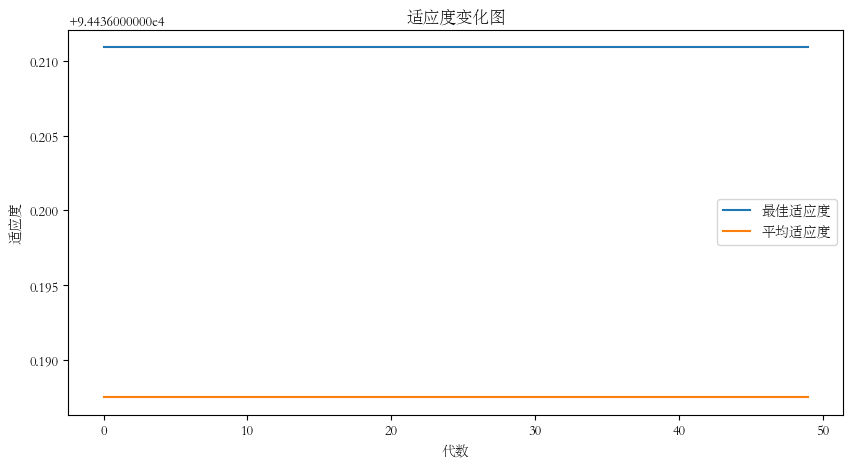

覆盖率：17.70%
第 2 次运行...
Generation 0: Best Fitness = 94436.2109375
Generation 1: Best Fitness = 94436.2109375
Generation 2: Best Fitness = 94436.2109375
Generation 3: Best Fitness = 94436.2109375
Generation 4: Best Fitness = 94436.2109375
Generation 5: Best Fitness = 94436.2109375
Generation 6: Best Fitness = 94436.2109375
Generation 7: Best Fitness = 94436.2109375
Generation 8: Best Fitness = 94436.2109375
Generation 9: Best Fitness = 94436.2109375
Generation 10: Best Fitness = 94436.2109375
Generation 11: Best Fitness = 94436.2109375
Generation 12: Best Fitness = 94436.2109375
Generation 13: Best Fitness = 94436.2109375
Generation 14: Best Fitness = 94436.2109375
Generation 15: Best Fitness = 94436.2109375
Generation 16: Best Fitness = 94436.2109375
Generation 17: Best Fitness = 94436.2109375
Generation 18: Best Fitness = 94436.2109375
Generation 19: Best Fitness = 94436.2109375
Generation 20: Best Fitness = 94436.2109375
Generation 21: Best Fitness = 94436.2109375
Generation 22: Best 

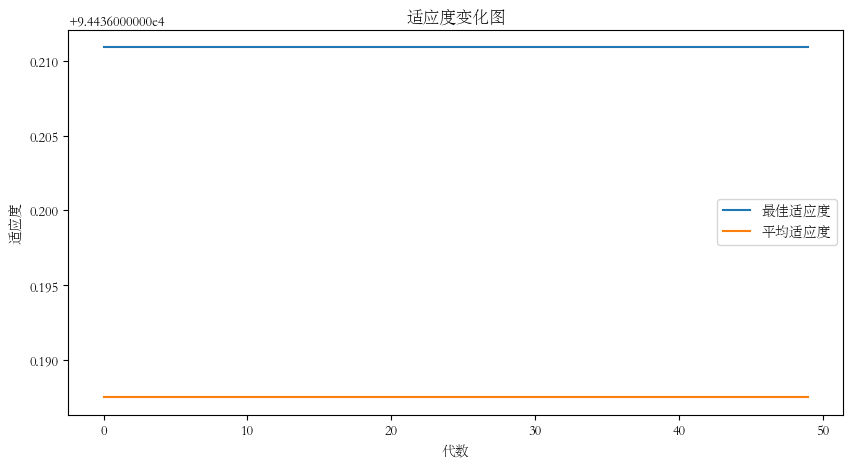

覆盖率：17.70%
已保存 29 个最佳候选点到文件 '../result/全部重插入/调整现有监测点布局最佳监测点_29_points.shp'
监测点数：29 - 最佳覆盖率：17.70%
运行遗传算法，监测点数量：51
调整后的最大迭代次数: 60
第 1 次运行...
Generation 0: Best Fitness = 153618.34375
Generation 1: Best Fitness = 153741.921875
Generation 2: Best Fitness = 163404.5625
Generation 3: Best Fitness = 161672.359375
Generation 4: Best Fitness = 168449.796875
Generation 5: Best Fitness = 168449.796875
Generation 6: Best Fitness = 168449.796875
Generation 7: Best Fitness = 168449.796875
Generation 8: Best Fitness = 169641.734375
Generation 9: Best Fitness = 169641.734375
Generation 10: Best Fitness = 171075.75
Generation 11: Best Fitness = 173685.375
Generation 12: Best Fitness = 173851.8125
Generation 13: Best Fitness = 174389.84375
Generation 14: Best Fitness = 177628.390625
Generation 15: Best Fitness = 180806.4375
Generation 16: Best Fitness = 180806.4375
Generation 17: Best Fitness = 178888.015625
Generation 18: Best Fitness = 178888.015625
Generation 19: Best Fitness = 181283.890625
Generat

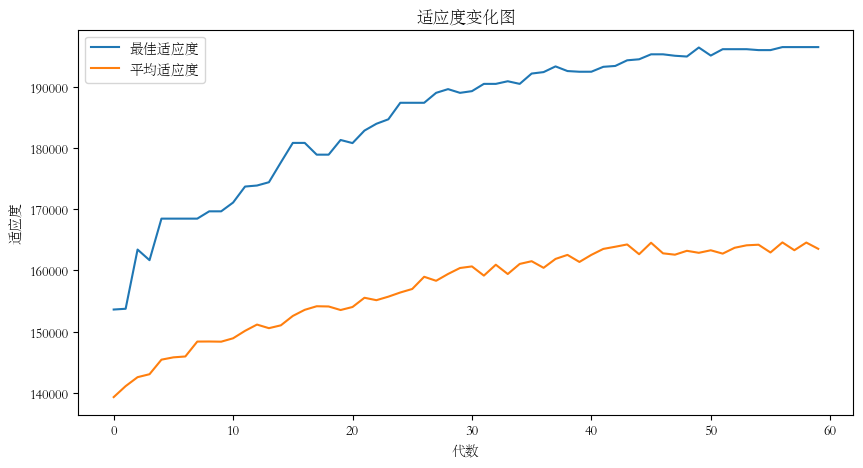

覆盖率：36.81%
第 2 次运行...
Generation 0: Best Fitness = 156101.296875
Generation 1: Best Fitness = 157240.84375
Generation 2: Best Fitness = 162789.359375
Generation 3: Best Fitness = 167326.75
Generation 4: Best Fitness = 164904.296875
Generation 5: Best Fitness = 165614.5625
Generation 6: Best Fitness = 169291.765625
Generation 7: Best Fitness = 172894.453125
Generation 8: Best Fitness = 171368.9375
Generation 9: Best Fitness = 171492.90625
Generation 10: Best Fitness = 173751.484375
Generation 11: Best Fitness = 177464.484375
Generation 12: Best Fitness = 176436.78125
Generation 13: Best Fitness = 175650.71875
Generation 14: Best Fitness = 179036.46875
Generation 15: Best Fitness = 180613.8125
Generation 16: Best Fitness = 180613.8125
Generation 17: Best Fitness = 180517.609375
Generation 18: Best Fitness = 180775.96875
Generation 19: Best Fitness = 181504.09375
Generation 20: Best Fitness = 182478.90625
Generation 21: Best Fitness = 183970.515625
Generation 22: Best Fitness = 183970.515

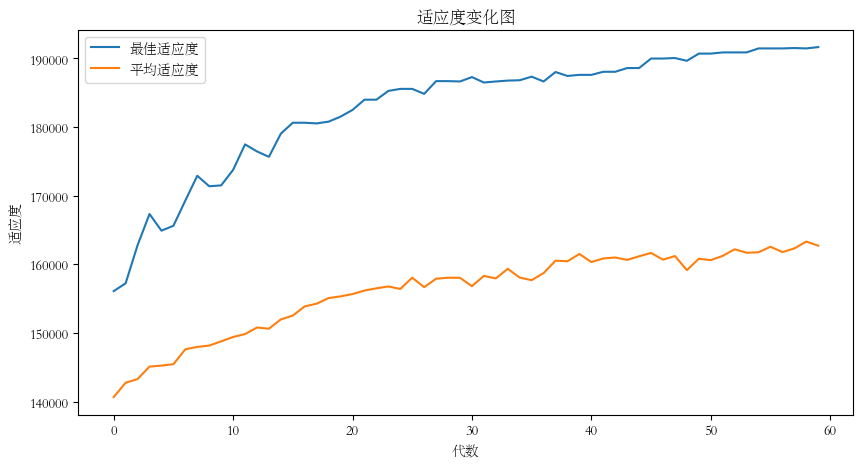

覆盖率：35.91%
已保存 51 个最佳候选点到文件 '../result/全部重插入/调整现有监测点布局最佳监测点_51_points.shp'
监测点数：51 - 最佳覆盖率：36.81%


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 初始化参数
pop_size = 50  # 种群大小
crossover_rate = 0.8  # 交叉概率
mutation_rate = 0.08  # 变异概率
base_generations = 50  # 基础迭代次数
runs_per_point_count = 2  # 每个监测点数量下的运行次数
increment = 22  # 每次增加的监测点数量
min_points = len(fixed_indices)  # 从固定的保留点数量开始
max_points = min_points + increment   # 最大监测点数量，可以根据实际情况调整

# 创建一个空的字典来保存不同监测点数量下的最佳覆盖率和最佳个体
best_coverage_results = {}
best_individuals = {}

# 迭代不同的监测点数量
for num_points in range(min_points, max_points + 1, increment):
    print(f"运行遗传算法，监测点数量：{num_points}")
    
    best_coverages = []
    individuals = []

    # 根据监测点数量动态调整最大迭代次数
    # 可以基于增加的监测点数量调整迭代次数，例如，每增加 15 个监测点，增加 10 次迭代。
    adjusted_generations = base_generations + (num_points - min_points) // increment * 10
    print(f"调整后的最大迭代次数: {adjusted_generations}")

    for run_number in range(runs_per_point_count):
        print(f"第 {run_number + 1} 次运行...")

        # 初始化遗传算法
        ga = GeneticAlgorithm(
            pop_size=pop_size,
            num_candidates=num_candidates,
            crossover_rate=crossover_rate,
            mutation_rate=mutation_rate,
            max_generations=adjusted_generations,  # 使用调整后的最大迭代次数
            num_selected_points=num_points,
            fixed_indices=fixed_indices,
        )

        # 运行遗传算法
        best_individual = ga.evolve(candidate_points_gdf, buffer_gdf,human_activity_raster)

        # 使用适应度作为覆盖的总强度
        total_covered_intensity = best_individual.fitness

        # 计算覆盖率
        coverage_ratio = total_covered_intensity / total_value
        best_coverages.append(coverage_ratio)
        individuals.append(best_individual)
        print(f"覆盖率：{coverage_ratio:.2%}")

    # 找到最佳个体的覆盖率
    max_coverage = max(best_coverages)
    best_coverage_results[num_points] = max_coverage

    # 找到覆盖率最高的个体
    best_index = best_coverages.index(max_coverage)
    best_individuals[num_points] = individuals[best_index]  # 保存该点数下的最佳个体

    # 保存最佳个体的候选点
    save_best_individual_points(candidate_points_gdf, best_individuals[num_points], num_points)

    print(f"监测点数：{num_points} - 最佳覆盖率：{max_coverage:.2%}")




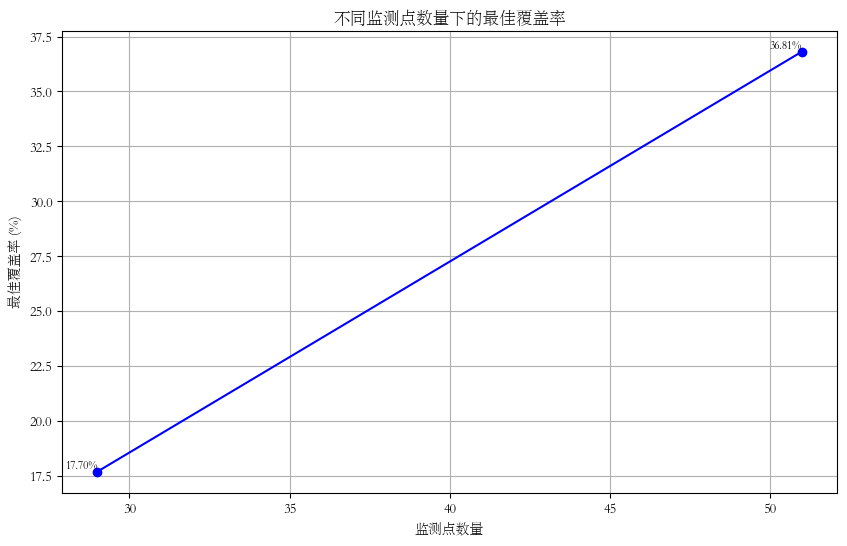

In [13]:
import matplotlib.pyplot as plt

# 设置字体为中文字体
plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['axes.unicode_minus'] = False

# 绘制最佳覆盖率曲线
plt.figure(figsize=(10, 6))
plt.plot(list(best_coverage_results.keys()), [v * 100 for v in best_coverage_results.values()], marker='o', linestyle='-', color='b')

# 在每个点上添加覆盖率的文本标签
for num_points, coverage in best_coverage_results.items():
    plt.text(num_points, coverage * 100, f'{coverage * 100:.2f}%', fontsize=8, ha='right', va='bottom')

plt.xlabel('监测点数量')
plt.ylabel('最佳覆盖率 (%)')
plt.title('不同监测点数量下的最佳覆盖率')

plt.grid(True)
plt.show()
